In [16]:
import csv
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Dropout, Cropping2D

# Array to append all the entries present in the .csv file
samples = [] 

# Extract all the log file data into samples array
with open('./training_data_with_recovery/driving_log.csv') as csvfile: 
    reader = csv.reader(csvfile)
    
    # To skip the first record if it contains headings
    #next(reader, None) 
    
    for line in reader:
        samples.append(line)

# Splitting the dataset to train and validation set (20% of the dataset is validation set)
train_samples, validation_samples = train_test_split(samples,test_size=0.2) 

print("Done")
print("Samples", len(samples), "Train samp", len(train_samples), "Valid samp", len(validation_samples))


Done
Samples 4872 Train samp 3897 Valid samp 975


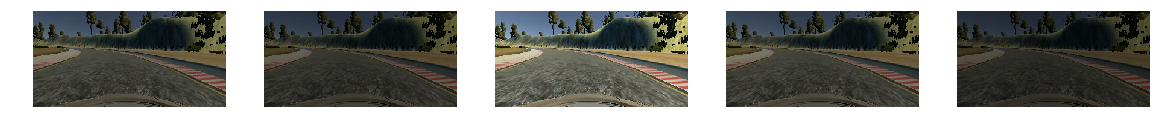

In [17]:
def randomBrigthness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

test_image = cv2.imread('./training_data_with_recovery/IMG/center_2018_10_21_01_00_57_091.jpg')
test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
for i in range(5):
    image_out = randomBrigthness(test_image)
    plt.subplot(1,5,i+1)
    plt.imshow(image_out)
    plt.axis('off')

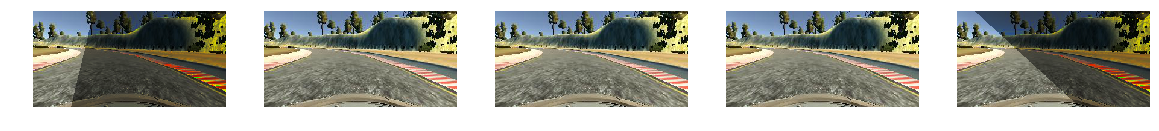

In [18]:
def randomShadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright   
            
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

plt.figure(figsize=(20,10))
for i in range(5):
    image_out = randomShadow(test_image)
    plt.subplot(1,5,i+1)
    plt.imshow(image_out)
    plt.axis('off')

In [19]:
# Code for generator
def generator(samples, batch_size=32):
    num_samples = len(samples)
   
    while 1: 
        # Shuffle data
        shuffle(samples) 
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            
            # Extracting 3 images, first one is center, second is left and third is right
            for batch_sample in batch_samples:
                    for i in range(3): 
                        name = './training_data_with_recovery/IMG/'+ batch_sample[i].split('/')[-1]
                        # CV2 reads an image in BGR we need to convert it to RGB since drive.py uses RGB
                        center_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB) 
                        # Extract the steering angle measurement
                        center_angle = float(batch_sample[3]) 
                        
                        # Random Brigthness and random shadow augmentation
                        images.append(randomShadow(randomBrigthness(center_image)))
                        
                        # introducing correction for left and right images
                        # if image is in left we increase the steering angle by 0.25
                        # if image is in right we decrease the steering angle by 0.25
                        
                        if(i==0):
                            angles.append(center_angle)
                        elif(i==1):
                            angles.append(center_angle+0.25)
                        elif(i==2):
                            angles.append(center_angle-0.25)
                        
                        # Code for Augmentation of data.
                        # We take the image and just flip it and negate the measurement
                        
                        images.append(cv2.flip(center_image,1))
                        if(i==0):
                            angles.append(center_angle*-1)
                        elif(i==1):
                            angles.append((center_angle+0.25)*-1)
                        elif(i==2):
                            angles.append((center_angle-0.25)*-1)  
                                                          
            X_train = np.array(images)
            y_train = np.array(angles)
            
            # Instead of holding the values of X_train and y_train, we yield the values which means we hold until the generator is running
            yield sklearn.utils.shuffle(X_train, y_train) 

# Compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [20]:
model = Sequential()

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

# trim image to only see section with road
model.add(Cropping2D(cropping=((70,25),(0,0))))    

# Layer 1- Convolution, no of filters- 24, filter size= 5x5, stride= 2x2
model.add(Conv2D(24, (5, 5), activation="elu", strides=(2, 2)))

# Layer 2- Convolution, no of filters- 36, filter size= 5x5, stride= 2x2
model.add(Conv2D(36, (5, 5), activation="elu", strides=(2, 2)))

# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.5))

# Layer 3- Convolution, no of filters- 48, filter size= 5x5, stride= 2x2
model.add(Conv2D(48, (5, 5), activation="elu", strides=(2, 2)))

# Layer 4- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Conv2D(64, (3, 3), activation="elu"))

# Layer 5- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Conv2D(64, (3, 3), activation="elu"))

# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.5))

# Flatten image 
model.add(Flatten())

# Layer 6- fully connected layer 1
model.add(Dense(100, activation="elu"))

# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.5))

# Layer 7- fully connected layer 2
model.add(Dense(50, activation="elu"))

# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.5))

# Layer 8- fully connected layer 3
model.add(Dense(10, activation="elu"))

#layer 9- fully connected layer 4
model.add(Dense(1))

# Output is the steering angle and hence using mean squared error loss function is the right choice for this regression problem
model.compile(loss='mse',optimizer='adam')

# Batch size
batch_size = 32

#fit generator is used here as the number of images are generated by the generator
model.fit_generator(train_generator, steps_per_epoch=len(train_samples), 
                    validation_data=validation_generator, validation_steps=len(validation_samples),
                    epochs=5, verbose=1)

#saving model
model.save('modelRecovery.h5')

print('Done! Model Saved!')

# keras method to print the model summary
model.summary()

Epoch 1/5
3897/3897 [==============================] - 2527s 648ms/step - loss: 0.0783 - val_loss: 0.0747
Epoch 2/5
3897/3897 [==============================] - 2515s 645ms/step - loss: 0.0622 - val_loss: 0.0664
Epoch 3/5
3897/3897 [==============================] - 2520s 647ms/step - loss: 0.0512 - val_loss: 0.0635
Epoch 4/5
3897/3897 [==============================] - 2517s 646ms/step - loss: 0.0434 - val_loss: 0.0626
Epoch 5/5
3897/3897 [==============================] - 2517s 646ms/step - loss: 0.0384 - val_loss: 0.0597
Done! Model Saved!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_4 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 31, 158, 24)       